In [1]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from django import *
from matplotlib import pyplot as plt
import matplotlib as mpl
from hdf5manager import hdf5manager as h5
from pandas import pandas as pd
from pandas import DataFrame
from skimage.measure import label, regionprops
import scipy
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
from scipy.ndimage.filters import gaussian_filter, convolve
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.filters import maximum_filter
from scipy.stats import multivariate_normal as mvn
from scipy.spatial.distance import cdist
from skimage.morphology import disk, watershed
from skimage.morphology import erosion, dilation, opening, closing
from opticFlow import opticFlow as of
import colorsys
import wholeBrain as wb
from waveletAnalysis import waveletAnalysis as wave
import cv2
import os
import seaborn as sns
sns.set()



Error importing slackNotify.py
	 ERROR :  No module named 'slacker'


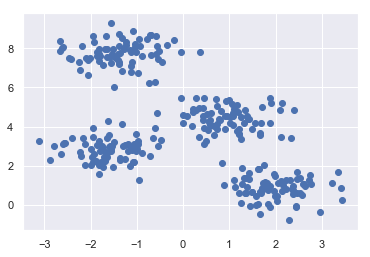

In [9]:
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

In [17]:
path = '/Users/jcrndm/Documents/'
file = 'test_angs_mags_metrics.csv'

tsv_output_file = path + file
data = pd.DataFrame.from_csv(tsv_output_file)

# print(data.head())

/Users/jcrndm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """


ValueError: Must pass DataFrame with boolean values only

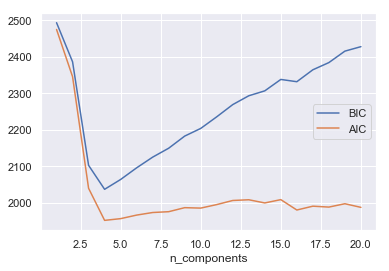

In [10]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [ ]:
gmm = GaussianMixture(n_components=4)
gmm.fit(X)


In [ ]:
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis');

In [ ]:
colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """


(4000, 26)


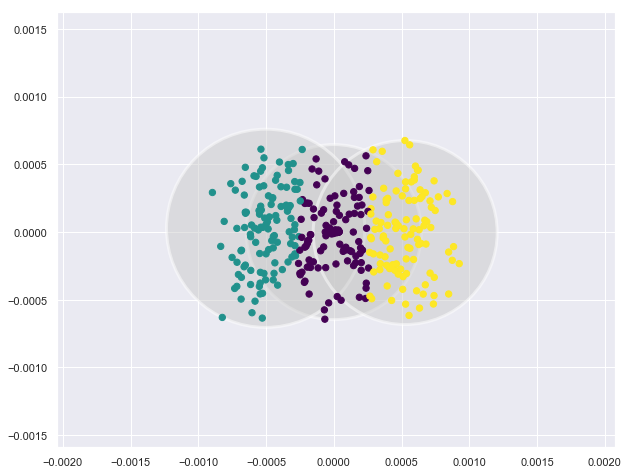

In [32]:
path = '/Users/jcrndm/Documents/'
file = 'test_angs_mags_metrics.csv'

tsv_output_file = path + file
data = pd.DataFrame.from_csv(tsv_output_file)

'''
In PCA you are maximizing the length of the vector to each of the points from the center point
of the data (mean value of each of the two variables you are dealing with), at the same time, 
MINIMIZING the distance from each point to the line that you drew.

Maximizing variance & Orthogonalization
'''

sklearn_pca = PCA(n_components = 26)
Y_sklearn = sklearn_pca.fit_transform(data)
print(Y_sklearn.shape)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(data)
prediction = kmeans.predict(data)

plt.figure(figsize = (10,8))
def plot_kmeans(kmeans, X, n_clusters=2, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
plot_kmeans(kmeans, Y_sklearn[:,18:20])

In [14]:
class GMM:
    def __init__(self, C, n_runs):
        self.C = C # number of Guassians/clusters
        self.n_runs = n_runs
        
    def get_params(self):
        return (self.mu, self.pi, self.sigma)
    
    
        
    def calculate_mean_covariance(self, X, prediction):
        d = X.shape[1]
        labels = np.unique(prediction)
        self.initial_means = np.zeros((self.C, d))
        self.initial_cov = np.zeros((self.C, d, d))
        self.initial_pi = np.zeros(self.C)
        
        counter=0
        for label in labels:
            ids = np.where(prediction == label) # returns indices
            self.initial_pi[counter] = len(ids[0]) / X.shape[0]
            self.initial_means[counter,:] = np.mean(X[ids], axis = 0)
            de_meaned = X[ids] - self.initial_means[counter,:]
            Nk = X[ids].shape[0] # number of data points in current gaussian
            self.initial_cov[counter,:, :] = np.dot(self.initial_pi[counter] * de_meaned.T, de_meaned) / Nk
            counter+=1
        assert np.sum(self.initial_pi) == 1    
            
        return (self.initial_means, self.initial_cov, self.initial_pi)
    
    def _initialise_parameters(self, X):
        n_clusters = self.C
        kmeans = KMeans(n_clusters= n_clusters, init="k-means++", max_iter=500, algorithm = 'auto')
        fitted = kmeans.fit(X)
        prediction = kmeans.predict(X)
        self._initial_means, self._initial_cov, self._initial_pi = self.calculate_mean_covariance(X, prediction)
        
        
        return (self._initial_means, self._initial_cov, self._initial_pi)
    
    def _e_step(self, X, pi, mu, sigma):
        N = X.shape[0] 
        self.gamma = np.zeros((N, self.C))

        const_c = np.zeros(self.C)
        
        
        self.mu = self.mu if self._initial_means is None else self._initial_means
        self.pi = self.pi if self._initial_pi is None else self._initial_pi
        self.sigma = self.sigma if self._initial_cov is None else self._initial_cov

        for c in range(self.C):
            # Posterior Distribution using Bayes Rule
            self.gamma[:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c])

        # normalize across columns to make a valid probability
        gamma_norm = np.sum(self.gamma, axis=1)[:,np.newaxis]
        self.gamma /= gamma_norm

        return self.gamma

    def _m_step(self, X, gamma):
        N = X.shape[0] # number of objects
        C = self.gamma.shape[1] # number of clusters
        d = X.shape[1] # dimension of each object

        # responsibilities for each gaussian
        self.pi = np.mean(self.gamma, axis = 0)

        self.mu = np.dot(self.gamma.T, X) / np.sum(self.gamma, axis = 0)[:,np.newaxis]

        for c in range(C):
            x = X - self.mu[c, :] # (N x d)
            
            gamma_diag = np.diag(self.gamma[:,c])
            x_mu = np.matrix(x)
            gamma_diag = np.matrix(gamma_diag)

            sigma_c = x.T * gamma_diag * x
            self.sigma[c,:,:]=(sigma_c) / np.sum(self.gamma, axis = 0)[:,np.newaxis][c]

        return self.pi, self.mu, self.sigma
    
    def _compute_loss_function(self, X, pi, mu, sigma):
        N = X.shape[0]
        C = self.gamma.shape[1]
        self.loss = np.zeros((N, C))

        for c in range(C):
            dist = mvn(self.mu[c], self.sigma[c],allow_singular=True)
            self.loss[:,c] = self.gamma[:,c] * (np.log(self.pi[c]+0.00001)+dist.logpdf(X)-np.log(self.gamma[:,c]+0.000001))
        self.loss = np.sum(self.loss)
        return self.loss
    
    def fit(self, X):
        d = X.shape[1]
        self.mu, self.sigma, self.pi =  self._initialise_parameters(X)
        
        try:
            for run in range(self.n_runs):  
                self.gamma  = self._e_step(X, self.mu, self.pi, self.sigma)
                self.pi, self.mu, self.sigma = self._m_step(X, self.gamma)
                loss = self._compute_loss_function(X, self.pi, self.mu, self.sigma)
                
                if run % 10 == 0:
                    print("Iteration: %d Loss: %0.6f" %(run, loss))
        
        except Exception as e:
            print(e)
        
        return self

    def predict(self, X):
        labels = np.zeros((X.shape[0], self.C))
        
        for c in range(self.C):
            labels [:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c])
        labels  = labels.argmax(1)
        return labels 
    
    def predict_proba(self, X):
        post_proba = np.zeros((X.shape[0], self.C))
        
        for c in range(self.C):
            # Posterior Distribution using Bayes Rule
            post_proba[:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c])
    
        return post_proba
    

model = GMM(3, n_runs = 30)

print(type(Y_sklearn))

Y_sklearn[np.isnan(Y_sklearn)] = 0

fitted_values = model.fit(Y_sklearn)
predicted_values = model.predict(Y_sklearn)



# # compute centers as point of highest density of distribution
centers = np.zeros((3,2))
for i in range(model.C):
    density = mvn(cov=model.sigma[i], mean=model.mu[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]
    
plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=predicted_values ,s=50, cmap='viridis', zorder=1)

plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.5, zorder=2);

w_factor = 0.2 / model.pi.max()
for pos, covar, w in zip(model.mu, model.sigma, model.pi):
    draw_ellipse(pos, covar, alpha = w)


<class 'numpy.ndarray'>


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


array must not contain infs or NaNs


ValueError: array must not contain infs or NaNs